VQE + ADAPT_VQE + TETRIS_VQE

In this part of the program, we compare VQE, ADAPT_VQE and TETRIS_VQE for BeH2 molecule using [1],[2],[3]. These are done successively and the time is noted. The goal of this part of the program is to try to look for methods with minimum time, most accuracy as well as minimum 2-qubit gates.

In [8]:
#Install the required packages
'''
!pip install qiskit
!pip install pennylane
!pip install qiskit_nature
!pip install scipy
'''

'\n!pip install qiskit\n!pip install pennylane\n!pip install qiskit_nature\n!pip install scipy\n'

In [9]:
#Load the required packages
import pennylane.numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA


from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

VQE

In [10]:
# Coordinates(val) are given in Angstrom
val = 1.291
Beh2 = [["Be", [0.0, 0.0, 0.0]],
        ["H", [-val, 0.0, 0.0]], 
        ["H", [val, 0.0, 0.0]]]
#define the molecule using qiskit_nature.drivers        
BeH2 = Molecule( 
    geometry=Beh2 , # The coordinates
    multiplicity=1, # 2*S + 1
    charge=0,
)
#define driver using qiskit_nature.drivers.second_quantization
driver = ElectronicStructureMoleculeDriver(BeH2, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [11]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  3
number of beta electrons:  3
number of spin orbitals:  14
nuclear repulsion energy:  3.4841257109372576


In [12]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")


#Now we remove/freeze the core orbital 1s of Be for the calculations
# Define the active space around the Fermi level 
transformer = ActiveSpaceTransformer(
    num_electrons=4, # Number of electrons in our active space
    num_molecular_orbitals=6, # Number of orbitals in our active space
)

# Now we can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [13]:
#Using paritymapper to take advantage of the Z2 symmetry of the system
mapper = ParityMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
#reduces the qubit number by 2
parity_converter = QubitConverter(mapper, two_qubit_reduction=True)    

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)


In [14]:
#Use UCCSD ansatz to look for single and double excitation on noiseless simulator
vqe_factory = VQEUCCFactory( 
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(maxiter=6,ftol = 1e-4),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

#Find the real solution using classical method
solver = GroundStateEigensolver(parity_converter, vqe_factory) 
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

Reference energy :  (-15.594081421715744+0j)


In [15]:
symbols = ["H","Be","H"]
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
#define the hamiltonian of the system
hamil = qml.qchem.molecular_hamiltonian(symbols,geometry,charge = 0,basis = 'sto-3g', active_electrons=4, active_orbitals=6)[0]
#number of qubits
n_qubits = len(hamil.wires)

#define the hf state
hf_state = qml.qchem.hf_state(electrons=4, orbitals=n_qubits)
# singles and doubles are used to make the AllSinglesDoubles template
singles, doubles = qml.qchem.excitations(4, n_qubits)

In [16]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 10



dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)


def cost(weights):
    qml.BasisState(hf_state, wires=list(range(n_qubits)))
    for i in range(len(singles)):            
        qml.SingleExcitation(weights[i+len(doubles)], wires=singles[i])
    for i in range(len(doubles)):
        qml.DoubleExcitation(weights[i], wires=doubles[i])        
    return qml.expval(hamil)

weights =np.zeros(len(doubles + singles), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.05)
i=0
iter=[]
cost_val=[]
Lowest_E=0
best_weights=0
for _ in range(30):
    weights = opt.step(cost, weights)
    iter.append(i)
    cost_fn=cost(weights)
    if Lowest_E>cost_fn:
        Lowest_E=cost_fn
        best_weights=weights
    cost_val.append(cost_fn)
    print('iter:',i,' cost_fn:',cost_fn)
    i=i+1

iter: 0  cost_fn: -15.58453351691457
iter: 1  cost_fn: -15.590131523137703
iter: 2  cost_fn: -15.588618210981616
iter: 3  cost_fn: -15.585171961432772
iter: 4  cost_fn: -15.585005155919756
iter: 5  cost_fn: -15.587042654078878
iter: 6  cost_fn: -15.588871736676003
iter: 7  cost_fn: -15.589834722917834
iter: 8  cost_fn: -15.59056486901048
iter: 9  cost_fn: -15.591372032489714
iter: 10  cost_fn: -15.591931740678662
iter: 11  cost_fn: -15.591932177550909
iter: 12  cost_fn: -15.591584663570536
iter: 13  cost_fn: -15.591367880744002
iter: 14  cost_fn: -15.591474861704368
iter: 15  cost_fn: -15.591795555078724
iter: 16  cost_fn: -15.59222393415359
iter: 17  cost_fn: -15.59275461347584
iter: 18  cost_fn: -15.59327819181099
iter: 19  cost_fn: -15.593527279447212
iter: 20  cost_fn: -15.593357949350608
iter: 21  cost_fn: -15.59297447001049
iter: 22  cost_fn: -15.592760333828322
iter: 23  cost_fn: -15.592895411021358
iter: 24  cost_fn: -15.593237294858296
iter: 25  cost_fn: -15.593536932764595
it

In [17]:
#Total number of 2-qubit (CNOT) gates
print("Total number of CNOT gates used = ", 13*len(doubles) + 2*len(singles)) 

Total number of CNOT gates used =  1020


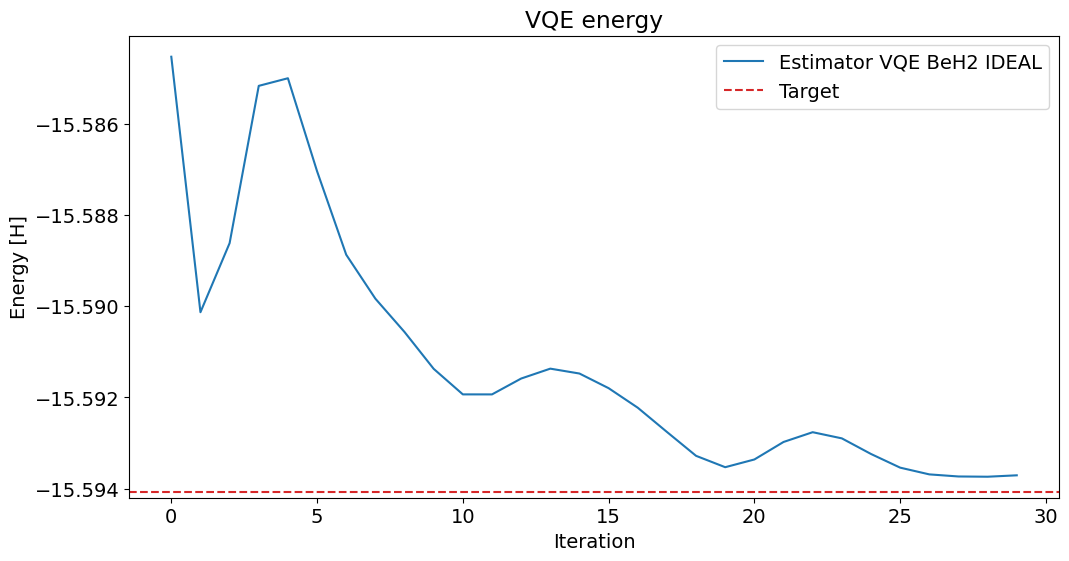

In [18]:
# The following plot is of full VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(cost_val, label="Estimator VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

ADAPT VQE

In [19]:
#We use pennylane for faster computation

#Define the symbol and geometry
symbols = ["H","Be","H"]
#Geometry in atomic distance for pennylane
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
active_electrons = 4
H, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    geometry,
    active_electrons=active_electrons,
    active_orbitals=6
)

print(f"Total number of excitations = {len(singles) + len(doubles)}")

Total number of excitations = 92


In [20]:


def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)
dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev)

circuit_gradient = qml.grad(cost_fn, argnum=0)

params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)

In [21]:
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]

In [22]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)

params_doubles = np.zeros(len(doubles_select), requires_grad=True)

for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)

grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)

In [23]:
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5 ]

In [24]:
cost_fn = qml.QNode(circuit_1, dev)

params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select
energy_vals = []
import time
for n in range(20):
    t1 = time.time()
    params, energy = opt.step_and_cost(cost_fn, params, excitations=gates_select)
    t2 = time.time()
    energy_vals.append(energy)
    print("n = {:},  E = {:.8f} H, t = {:.2f} s".format(n, energy, t2 - t1))

n = 0,  E = -15.56135211 H, t = 2.06 s
n = 1,  E = -15.58014760 H, t = 2.00 s
n = 2,  E = -15.58775020 H, t = 2.20 s
n = 3,  E = -15.59102148 H, t = 2.10 s
n = 4,  E = -15.59250983 H, t = 2.10 s
n = 5,  E = -15.59322462 H, t = 2.20 s
n = 6,  E = -15.59358749 H, t = 2.10 s
n = 7,  E = -15.59378268 H, t = 2.00 s
n = 8,  E = -15.59389401 H, t = 2.00 s
n = 9,  E = -15.59396115 H, t = 2.20 s
n = 10,  E = -15.59400369 H, t = 2.00 s
n = 11,  E = -15.59403176 H, t = 2.00 s
n = 12,  E = -15.59405087 H, t = 2.20 s
n = 13,  E = -15.59406418 H, t = 2.00 s
n = 14,  E = -15.59407361 H, t = 2.00 s
n = 15,  E = -15.59408036 H, t = 2.30 s
n = 16,  E = -15.59408523 H, t = 2.00 s
n = 17,  E = -15.59408878 H, t = 2.00 s
n = 18,  E = -15.59409136 H, t = 2.30 s
n = 19,  E = -15.59409325 H, t = 2.10 s


In [25]:
#Total number of 2 qubit gates used
print('Total number of CNOT qubit gates used =', 13*len(doubles_select) + 2*len(singles_select))

Total number of CNOT qubit gates used = 190


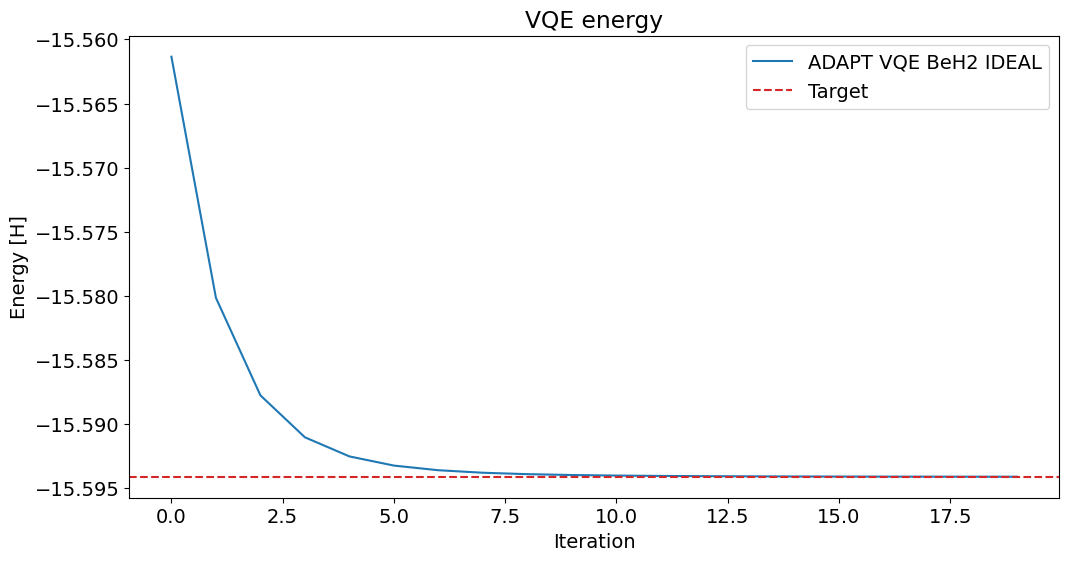

In [26]:
# The following plot is of ADAPT_VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(energy_vals, label="ADAPT VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

TETRIS_VQE

In [28]:




#Define the symbol and geometry
symbols = ["H","Be","H"]
#Geometry in atomic distance for pennylane
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
active_electrons = 4
H, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    geometry,
    charge = 0,
    active_electrons=active_electrons,
    basis = 'sto-3g',
    active_orbitals=6
)
n_qubits = qubits
#HF State
hf_state= qml.qchem.hf_state(electrons=active_electrons, orbitals=n_qubits)


#all the operators together
all_operators=singles+doubles

params = [0.0] * len(doubles+singles)
params=np.array(params )

#define the circuit again
def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(n_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(H )

    
    
dev = qml.device("default.qubit", wires=n_qubits)
cost_fn = qml.QNode(circuit_1, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads = circuit_gradient(params, excitations=doubles+singles)

#operators in the opposite manner
opposite_pool=doubles+singles

#Thresholding the excitations
new_opposite_pool=[opposite_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
#gradients for the excitations thresholded
new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
   
#Now we sort these gradients and we will apply it sequentially
indx=np.argsort(np.abs(new_grads))
sorted_opposite_pool=[new_opposite_pool[idx] for idx in indx]

#For the shallower circuit, we will use this
shallow_circuits=[]    
while len(sorted_opposite_pool) !=0:
    q_layer=[]     
    ind_left=[]  
    for idx, op in enumerate(sorted_opposite_pool):
        if shallow_circuits==[]:
            shallow_circuits.append(op)
            q_layer=q_layer+op
        else:
            Stack=True
            for k in op:
                if k in q_layer:
                    Stack=False
                    ind_left.append(idx)
                    break
            if Stack:
                shallow_circuits.append(op)
                q_layer=q_layer+op
    sorted_opposite_pool=[sorted_opposite_pool[idx] for idx in ind_left]

params = [0.0] * len(doubles_select+singles_select)
params=np.array(params )

q_layer=[]
time_iterations=20
conv_tol=1e-4
energy=[]

opt = qml.GradientDescentOptimizer(stepsize=0.3) 
dev = qml.device("default.qubit", wires=n_qubits)

cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
circuit_gradient = qml.grad(cost_fn, argnum=0) # step 2.

energy = [cost_fn(params, shallow_circuits)] # step 2.
print(f"time_iteration = 0,  Energy = {energy[-1]:.8f} Ha")
print("Number of gates = {}\n".format(len(shallow_circuits)))
configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
print("Circuit Depth = {}\n".format(configs['depth'],))
t1 = time.time()
for n in range(time_iterations):

    Test_set=shallow_circuits+all_operators
    Test_parameters=list(params)+[0.0]*len(all_operators)
    Test_parameters=np.array(Test_parameters)
        
    test_grads = circuit_gradient(Test_parameters,Test_set)
    test_grads = test_grads[len(params):]

    test_sorted_indx=np.argsort(np.abs(test_grads))[::-1]
    maxpos=test_sorted_indx[0]
    Larger_sorted_indx=[]
    for ind in test_sorted_indx:
        Larger_sorted_indx.append(ind)

    for k,ind in enumerate(Larger_sorted_indx):
        op_set=set(all_operators[ind])
        q_layer_set=set(q_layer)
        if not bool(op_set & q_layer_set):
            q_layer=q_layer+all_operators[ind]
            shallow_circuits.append(all_operators[ind])
            params=np.append(params, 0.0)
        if (len(q_layer)>=n_qubits-4): # It is hard to find the operators with non-zero gradient fill all qubit layers.
            q_layer=[]                                 # We leave at maximum 4 idle qubits
            break


    params,_ = opt.step(cost_fn, params, shallow_circuits) # Step 5.
    E_val=cost_fn(params, shallow_circuits)
    energy.append(E_val)
    conv = np.abs(real_solution_t.real - E_val) #step 3.

    print(f"time_iteration = {n+1}, Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(shallow_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))
    if conv <= conv_tol:
        break
t2 = time.time()

time_iteration = 0,  Energy = -15.56135211 Ha
Number of gates = 14

Circuit Depth = 8

time_iteration = 1, Energy = -15.57366875 Ha
Number of gates = 16

Circuit Depth = 9

time_iteration = 2, Energy = -15.58113881 Ha
Number of gates = 18

Circuit Depth = 10

time_iteration = 3, Energy = -15.58573604 Ha
Number of gates = 20

Circuit Depth = 11

time_iteration = 4, Energy = -15.58860691 Ha
Number of gates = 22

Circuit Depth = 12

time_iteration = 5, Energy = -15.59042490 Ha
Number of gates = 24

Circuit Depth = 13

time_iteration = 6, Energy = -15.59159140 Ha
Number of gates = 26

Circuit Depth = 14

time_iteration = 7, Energy = -15.59234926 Ha
Number of gates = 28

Circuit Depth = 15

time_iteration = 8, Energy = -15.59284751 Ha
Number of gates = 30

Circuit Depth = 16

time_iteration = 9, Energy = -15.59317890 Ha
Number of gates = 32

Circuit Depth = 17

time_iteration = 10, Energy = -15.59340185 Ha
Number of gates = 34

Circuit Depth = 18

time_iteration = 11, Energy = -15.59355358 

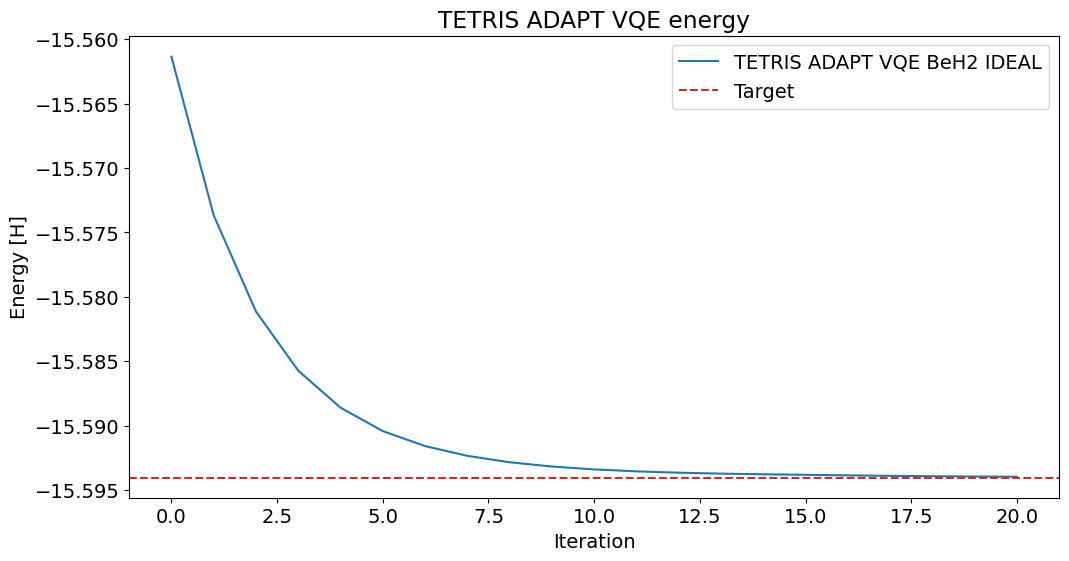

In [29]:
# The following plot is of ADAPT_VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(energy, label="TETRIS ADAPT VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("TETRIS ADAPT VQE energy")
plt.show()

In [30]:
num_two_gates = 0
for ele in shallow_circuits:
    if len(ele)==2:
        num_two_gates+=2
    else:
        num_two_gates+=13
print('Number of two qubit CNOT gates for TETRIS ADAPT VQE is', num_two_gates)

Number of two qubit CNOT gates for TETRIS ADAPT VQE is 603


In [31]:
print('Time taken =', t2-t1)

Time taken = 225.90832924842834


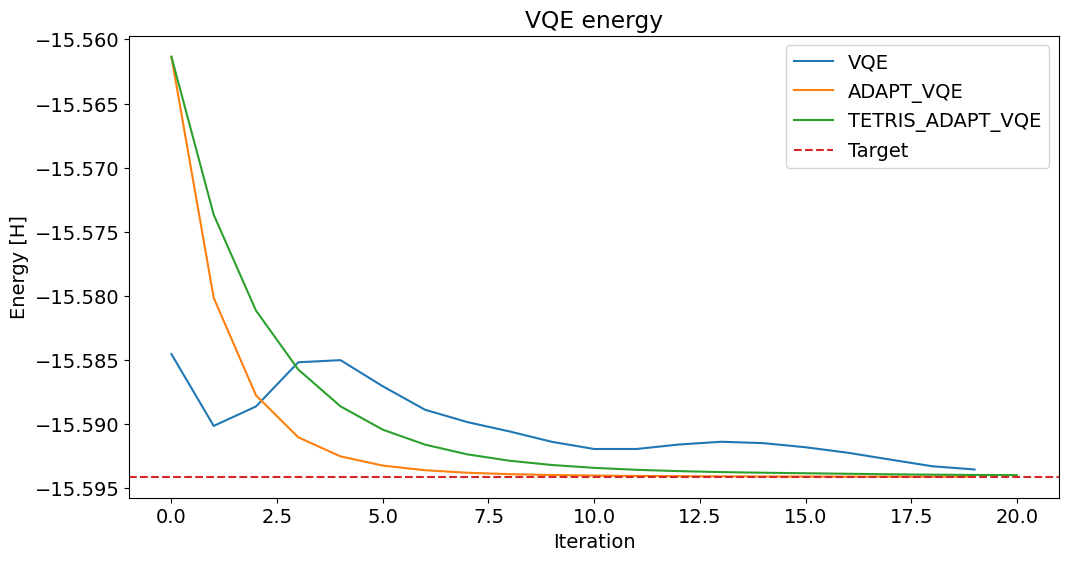

In [34]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(cost_val[:20], label="VQE")
plt.plot(energy_vals, label="ADAPT_VQE")
plt.plot(energy, label="TETRIS_ADAPT_VQE")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()